<a href="https://colab.research.google.com/github/bijmuj/SketchColorization/blob/master/v2/sketch_colorization_v2_noGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Thu Jul  8 09:54:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install -q wandb tensorflow-addons kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ktaebum/anime-sketch-colorization-pair

     |████████████████████████████████| 1.8MB 30.3MB/s 
     |████████████████████████████████| 686kB 34.8MB/s 
     |████████████████████████████████| 143kB 50.1MB/s 
     |████████████████████████████████| 174kB 52.4MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 


In [ ]:
! unzip -q /content/anime-sketch-colorization-pair.zip -x "data/data/*" "data/colorgram/*"

In [ ]:
import os
import glob
import time
import wandb
import numpy as np
from tqdm import tqdm
from google.colab import files

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
wandb.login()
run = wandb.init(project='sketch_colorization', entity='bijin')

wandb: Currently logged in as: bijin (use `wandb login --relogin` to force relogin)


In [ ]:
run.log({"something":5})

In [ ]:
BATCH_SIZE = 16
VAL_BATCH_SIZE = 6
BUFFER_SIZE = 800
EPOCHS = 5
LAMBDA_1 = 1
LAMBDA_2 = 1
LR = 2e-4
inititalizer = tf.random_normal_initializer(0, 0.02)
n_batches = 14224 / BATCH_SIZE

In [ ]:
config = wandb.config
config.batch_size = BATCH_SIZE
config.lambdas = [LAMBDA_1, LAMBDA_2]
config.losses = {"content":"l1_grayscale_label", "style":"l2_vgg_style"}
config.lr = LR

In [ ]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3)
    # cast and normalize
    image = tf.cast(image, tf.float32)/127.5 - 1
    w = tf.shape(image)[1]
    w = w // 2
    # split
    label = image[:, :w, :]
    sketch = image[:, w:, :]
    # resize
    label = tf.image.resize(label, (256, 256))
    sketch = tf.image.resize(sketch, (256, 256))
    return label, sketch

In [ ]:
dataset_path = glob.glob('/content/data/train/*.png')
train_dataset = tf.data.Dataset.from_tensor_slices(dataset_path)
train_dataset = train_dataset.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
dataset_path = glob.glob('/content/data/val/*.png')
val_dataset = tf.data.Dataset.from_tensor_slices(dataset_path)
val_dataset = val_dataset.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(100).batch(VAL_BATCH_SIZE)

In [ ]:
vgg = VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
    layer.trainable = False
vgg_model = tf.keras.models.Model(inputs = vgg.input, outputs=[vgg.get_layer("block5_pool").output,
                                                               vgg.get_layer("block4_pool").output,
                                                               vgg.get_layer("block3_pool").output])

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
def encoder_unit(input, filters, kernel, strides, norm="Instance"):
    x = input
    if norm=='Instance':
        x = tfa.layers.InstanceNormalization(axis=3, scale=True, center=True,
                                             beta_initializer='random_uniform',
                                             gamma_initializer='random_uniform')(x)

    x = layers.Conv2D(filters, kernel_size=kernel, strides=strides, padding='same', use_bias=False)(x)
    x = layers.LeakyReLU(0.2)(x)
    
    return x

In [ ]:
def decoder_unit(input, skip, filters, kernel, strides, style=None, norm='Instance'):
    x = input
    if norm=='Instance':
        x = tfa.layers.InstanceNormalization(axis=3, scale=True, center=True,
                                             beta_initializer='random_uniform',
                                             gamma_initializer='random_uniform')(x)

    x = layers.Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding='same', use_bias=False)(x)

    x = layers.add([x, skip])
    if style!=None:
        x = layers.Concatenate()([x, style])

    x = layers.Conv2D(filters, kernel_size=3, strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.LeakyReLU(0.2)(x)
    
    return x

In [ ]:
def generator_model():
    skips = []
    feats = [64, 128, 256, 512, 512]
    norms = [None]
    norms += ['Instance'] * 4

    vgg_style = [layers.Input((8, 8, 512), name='Style_8'),
                 layers.Input((16, 16, 512), name='Style_16'),
                 layers.Input((32, 32, 256), name='Style_32')]
                 
    content = layers.Input((256, 256, 3), name='Content')
    x = content

    for idx, f in enumerate(feats):
        x = encoder_unit(x, f, (4, 4), (2, 2), norm=norms[idx])
        skips.insert(0, x)

    norms = norms[::-1]
    feats = feats[::-1]

    x = layers.Conv2D(512, 4, strides=(2, 2), padding='same', use_bias=False)(x)

    for idx, f in enumerate(feats):
        v = vgg_style[idx] if idx < 3 else None
        x = decoder_unit(x, skips[idx], f, kernel=(4, 4), strides=(2, 2), style=v, norm=norms[idx])

    x = layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.Conv2D(3, kernel_size=3, strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    return tf.keras.models.Model(inputs = [vgg_style, content], outputs=[x])

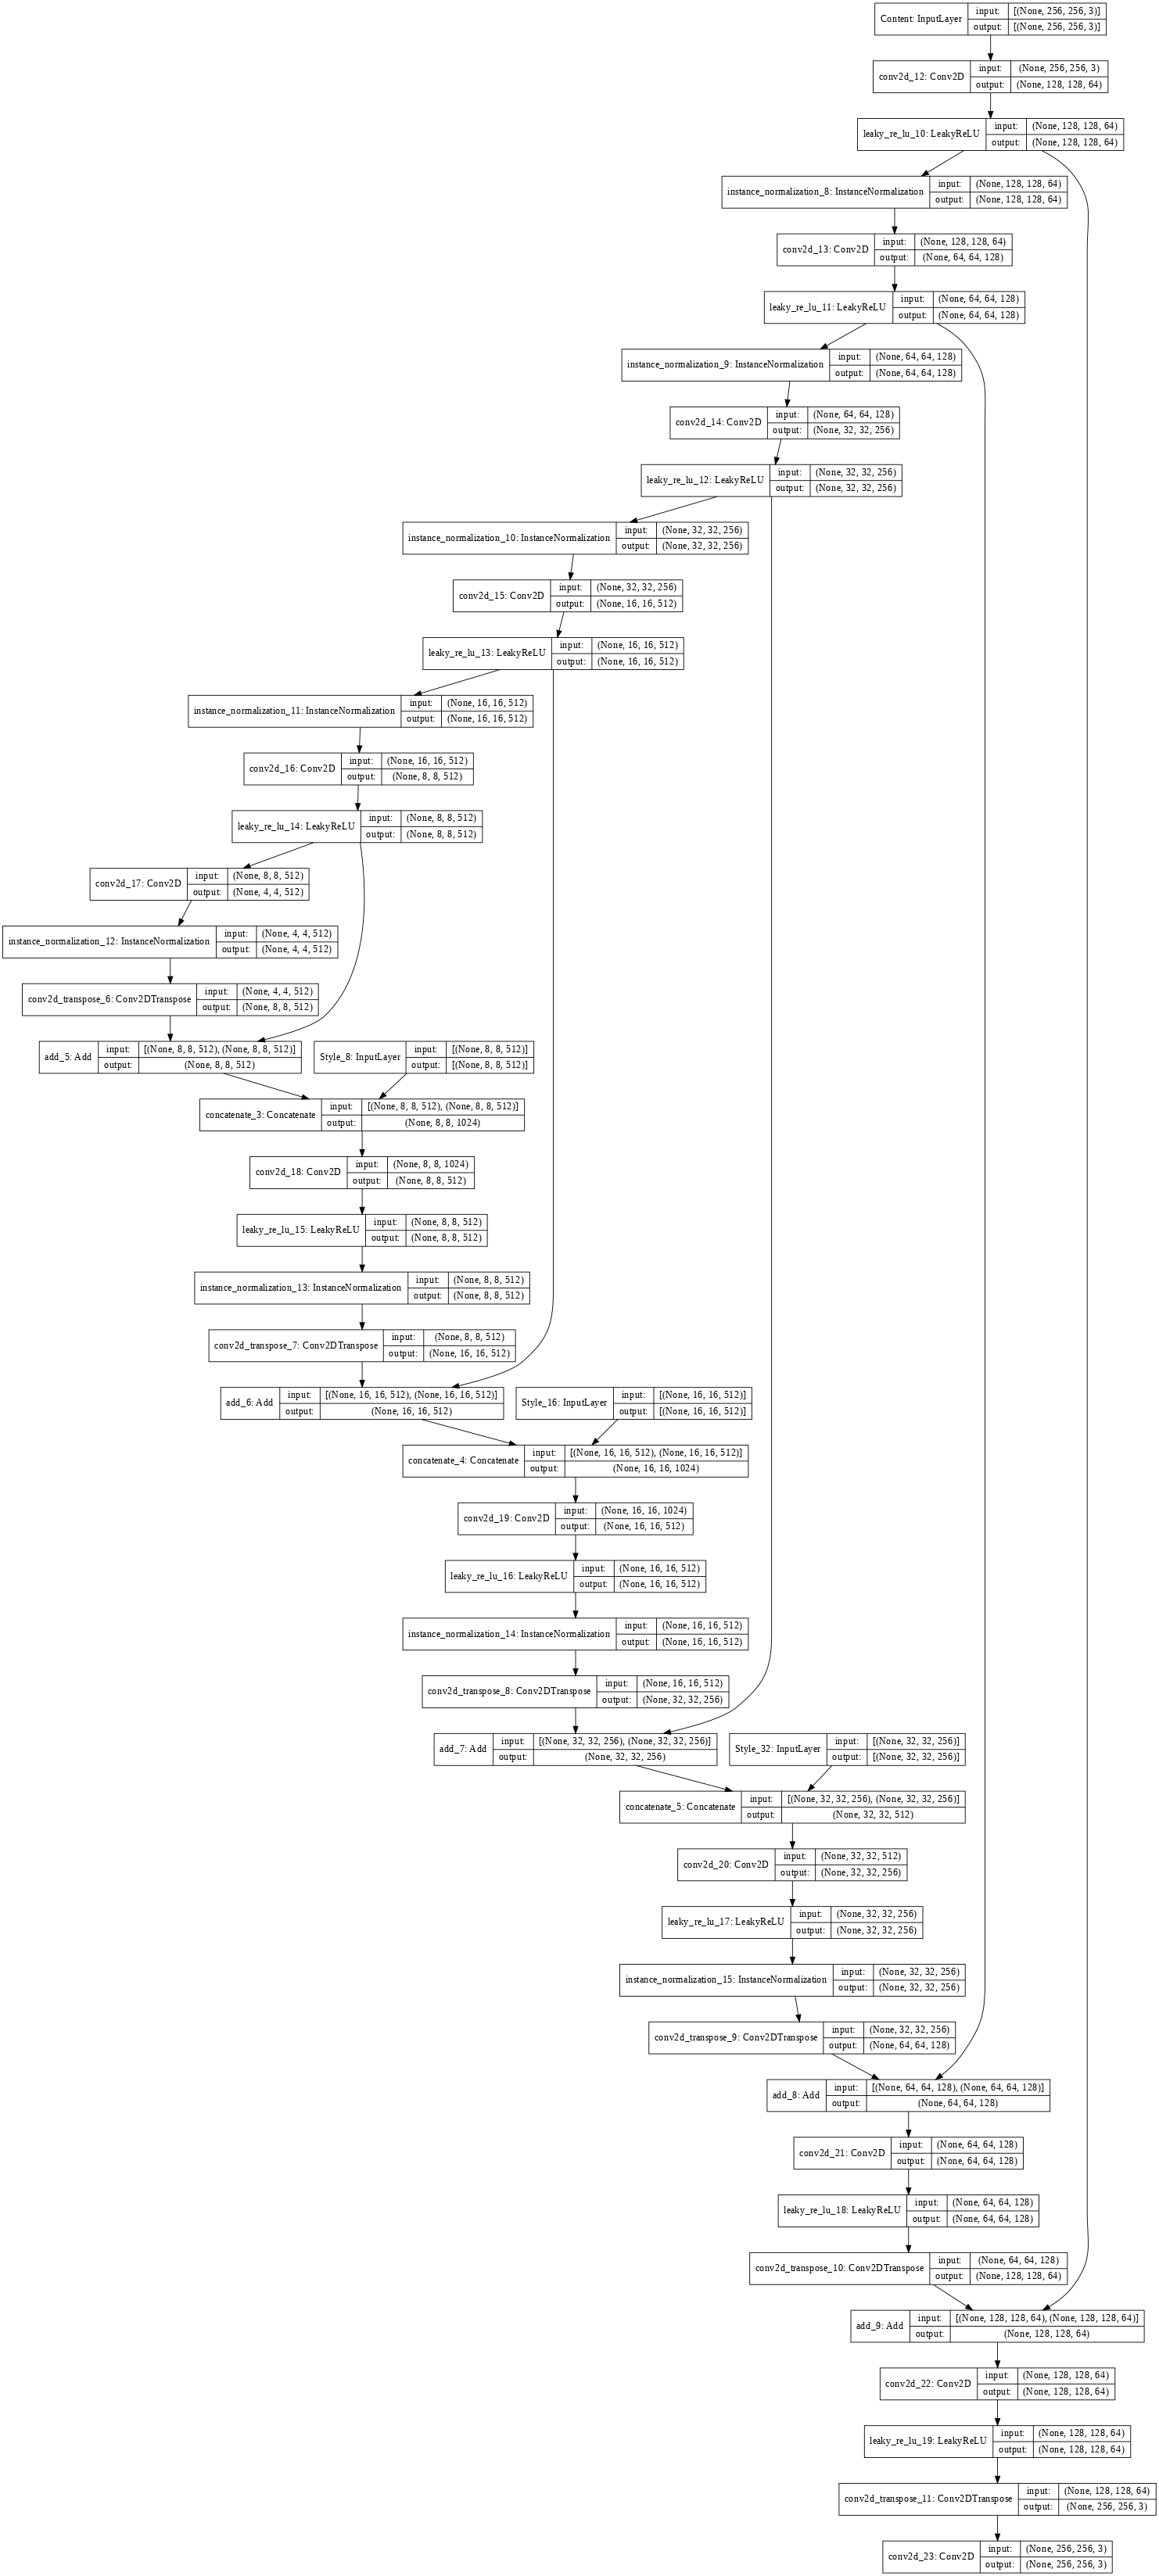

In [ ]:
generator = generator_model()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
l1_loss = MeanAbsoluteError()
l2_loss = MeanSquaredError()

In [ ]:
def generator_loss(out, label, vgg_label, vgg_out):
    out = tf.image.rgb_to_grayscale(out)
    label = tf.image.rgb_to_grayscale(label)
    l1 = l1_loss(out, label)
    vgg_loss = l2_loss(vgg_out, vgg_label)
    total = l1 * LAMBDA_1 + vgg_loss * LAMBDA_2
    return total, l1, vgg_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5, beta_2=0.999)

In [ ]:
checkpoint_dir = 'drive/MyDrive/sc_v2_noGAN'
checkpoint = tf.train.Checkpoint(generator=generator,
                                 generator_optimizer=generator_optimizer)  
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)  

In [ ]:
def display(label, sketch, output):
    images = [label[0], sketch[0], output[0]]
    plt.figure(figsize = (15, 15))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

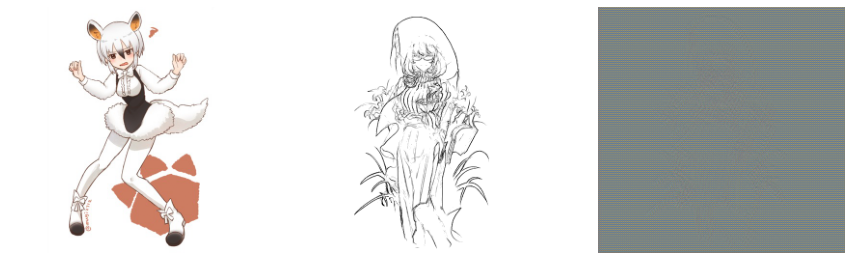

In [ ]:
for labels, sketches in train_dataset.take(1):
    vgg_out = vgg_model.predict(labels[::-1])
    imgs = generator([vgg_out, sketches], training = False)
    display(labels[::-1], sketches, imgs)

In [ ]:
def log(g_losses, color, sketch, output, n=VAL_BATCH_SIZE):
    images = []
    for i in range(n):
        img_row = np.hstack([color[i], sketch[i], output[i]]) * 0.5 + 0.5
        images.append(img_row)
    images = wandb.Image(np.vstack(images), caption="Left: Color, Mid: Sketch, Right: Output")
    wandb.log({"g_loss": g_losses[0],
               "l1_loss": g_losses[1],
               "vgg_loss": g_losses[2],
               "examples": images})

In [ ]:
@tf.function
def train_step(labels, sketches):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        vgg_style = vgg_model(labels, training=False)
        generated_images = generator([vgg_style, sketches], training=True)
        
        vgg_label = vgg_style[0]
        vgg_out = vgg_model(generated_images, training=False)[0]

        gen_total, gen_l1, gen_vgg = generator_loss(generated_images, labels[::-1],
                                                    vgg_label, vgg_out)

    gradients_of_generator = gen_tape.gradient(gen_total, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return gen_total, gen_l1, gen_vgg

In [ ]:
def train():
    checkpoint.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("\nRestored from {}".format(manager.latest_checkpoint))
        start = int(manager.latest_checkpoint.split('-')[-1])
    else:
        print("\nInitializing from scratch.")
        start = 0

    val_iter = iter(val_dataset)
    for epoch in range(start, EPOCHS):
        g_losses = []
        l1_losses = []
        vgg_losses = []
        print(f'\nEpoch: {epoch + 1} of {EPOCHS}')
        named_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", named_tuple)
        print("Started: " + time_string)

        for n, (labels, sketches) in tqdm(train_dataset.enumerate(), total=n_batches):
            g_total, g_l1, g_vgg = train_step(labels[::-1], sketches)
            g_losses.append(g_total)
            l1_losses.append(g_l1)
            vgg_losses.append(g_vgg)
        g_loss = np.mean(np.array(g_losses))
        l1_loss = np.mean(np.array(l1_losses))
        vgg_loss = np.mean(np.array(vgg_losses))

        print(f'Generator loss: {g_loss}')
        path = manager.save()
        print(f'Checkpoint saved at {checkpoint_dir}')

        labels, sketches = val_iter.next()
        labels = labels[::-1]
        vgg_style = vgg_model.predict(labels)
        imgs = generator([vgg_style, sketches], training=False)

        log([g_loss, l1_loss, vgg_loss], labels, sketches, imgs)

In [ ]:
train()

  0%|          | 0/889.0 [00:00<?, ?it/s]


Initializing from scratch.

Epoch: 1 of 5
Started: 07/08/2021, 10:08:46


100%|██████████| 889/889.0 [08:21<00:00,  1.77it/s]


Generator loss: 0.3163380026817322
Checkpoint saved at drive/MyDrive/sc_v2_noGAN


  0%|          | 0/889.0 [00:00<?, ?it/s]


Epoch: 2 of 5
Started: 07/08/2021, 10:17:14


100%|██████████| 889/889.0 [08:21<00:00,  1.77it/s]


Generator loss: 0.2774689495563507
Checkpoint saved at drive/MyDrive/sc_v2_noGAN


  0%|          | 0/889.0 [00:00<?, ?it/s]


Epoch: 3 of 5
Started: 07/08/2021, 10:25:39


100%|██████████| 889/889.0 [08:21<00:00,  1.77it/s]


Generator loss: 0.26519671082496643
Checkpoint saved at drive/MyDrive/sc_v2_noGAN


  0%|          | 0/889.0 [00:00<?, ?it/s]


Epoch: 4 of 5
Started: 07/08/2021, 10:34:04


100%|██████████| 889/889.0 [08:06<00:00,  1.83it/s]


Generator loss: 0.25684571266174316
Checkpoint saved at drive/MyDrive/sc_v2_noGAN


  0%|          | 0/889.0 [00:00<?, ?it/s]


Epoch: 5 of 5
Started: 07/08/2021, 10:42:13


100%|██████████| 889/889.0 [08:13<00:00,  1.80it/s]


Generator loss: 0.23615577816963196
Checkpoint saved at drive/MyDrive/sc_v2_noGAN


In [ ]:
! wandb sync wandb/latest-run

Syncing: https://wandb.ai/bijin/sketch_colorization/runs/39uwggwg ...wandb: WARNING .wandb file is incomplete (record checksum is invalid, data may be corrupt), be sure to sync this run again once it's finished
done.


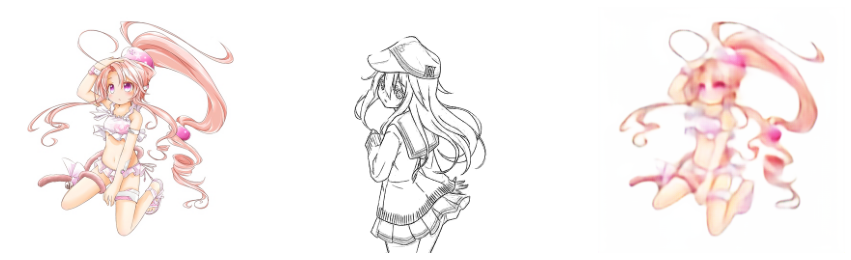

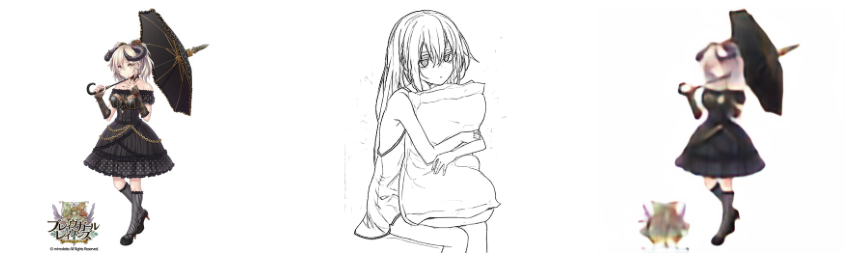

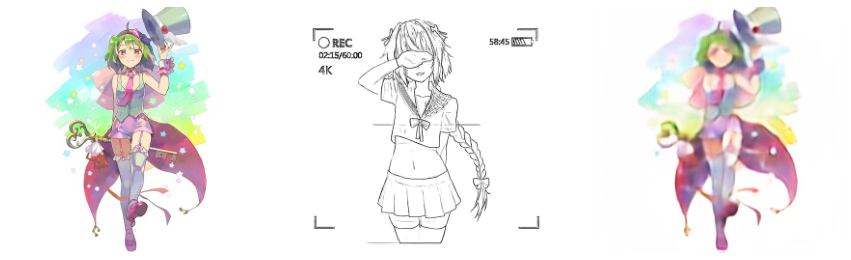

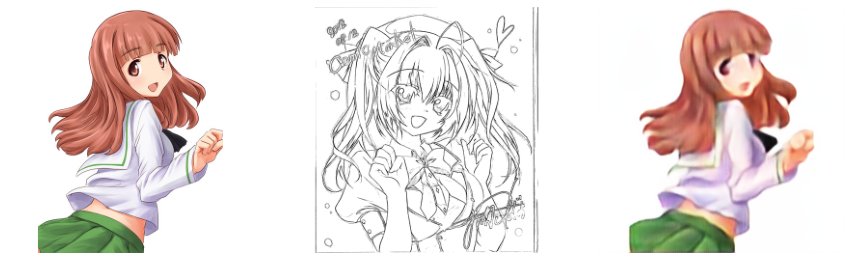

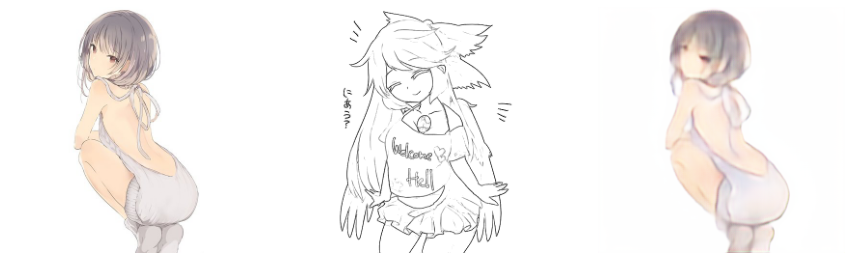

In [ ]:
for labels, sketches in val_dataset.take(5):
    labels = labels[::-1] 
    vgg_style = vgg_model.predict(labels)
    imgs = generator([vgg_style, sketches], training = False)
    display(labels, sketches, imgs)

In [ ]:
generator.save('./sc_v2_gen.h5')
discriminator.save('./sc_v2_disc.h5')
model_artifact = wandb.Artifact("v2", type='model',
                                description='unet with vgg features added at bottleneck')
model_artifact.add_file('./sc_v2_gen.h5')
model_artifact.add_file('./sc_v2_disc.h5')
run.log_artifact(model_artifact)